# Carregamento do DataSet

In [1]:
%reload_ext autoreload
%autoreload 2

from variables import filenames, features, target
from load_dataset import load
from pre_processing import apply
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = load(filenames)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


# Preprocessamento

## Substituindo valores faltantes pela media

In [3]:
apply(df)

Quantidade de valores alterados:  3128


# Analise do Dataset

In [4]:
df.columns = df.columns.str.strip()
select_colums = ["Destination Port", "Total Fwd Packets", "Total Backward Packets", "Total Length of Fwd Packets", "Total Length of Bwd Packets", "Flow Duration", "Flow Packets/s", "Flow Bytes/s", "Down/Up Ratio", "Label"]
df = df[select_colums]
df.head()

,Destination Port,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Flow Duration,Flow Packets/s,Flow Bytes/s,Down/Up Ratio,Label
0,54865,2,0,12,0,3,666666.66670,4.000000e+06,0,BENIGN
1,55054,1,1,6,6,109,18348.62385,1.100917e+05,1,BENIGN
2,55055,1,1,6,6,52,38461.53846,2.307692e+05,1,BENIGN
3,46236,1,1,6,6,34,58823.52941,3.529412e+05,1,BENIGN
4,54863,2,0,12,0,3,666666.66670,4.000000e+06,0,BENIGN


In [5]:
df["Class"] = (df["Label"] != "BENIGN").astype(int)
df.drop(["Label"], axis=1 ,inplace=True)
df.head()

,Destination Port,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Flow Duration,Flow Packets/s,Flow Bytes/s,Down/Up Ratio,Class
0,54865,2,0,12,0,3,666666.66670,4.000000e+06,0,0
1,55054,1,1,6,6,109,18348.62385,1.100917e+05,1,0
2,55055,1,1,6,6,52,38461.53846,2.307692e+05,1,0
3,46236,1,1,6,6,34,58823.52941,3.529412e+05,1,0
4,54863,2,0,12,0,3,666666.66670,4.000000e+06,0,0


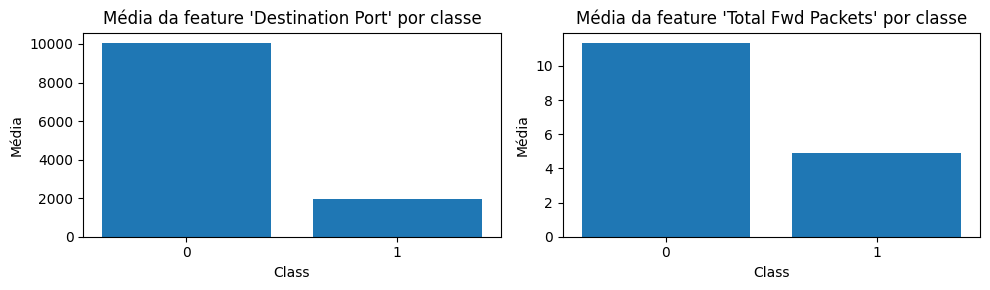

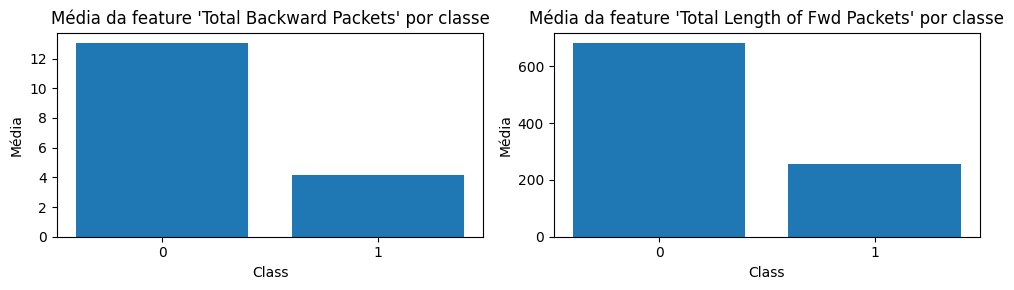

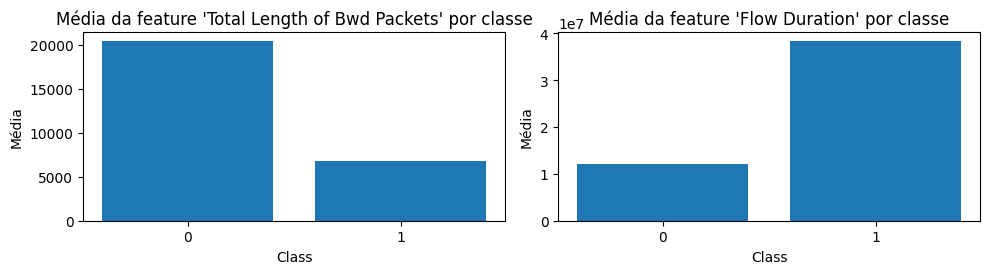

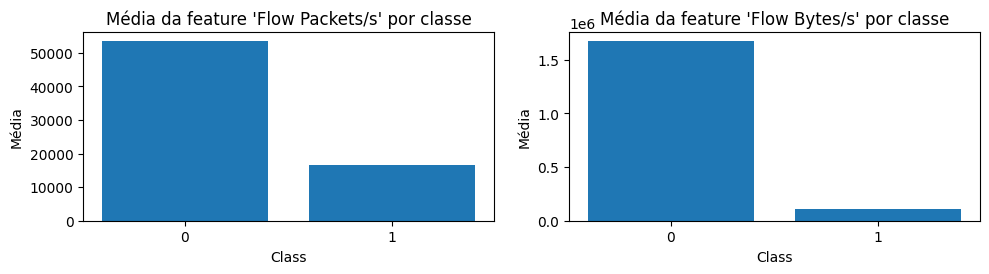

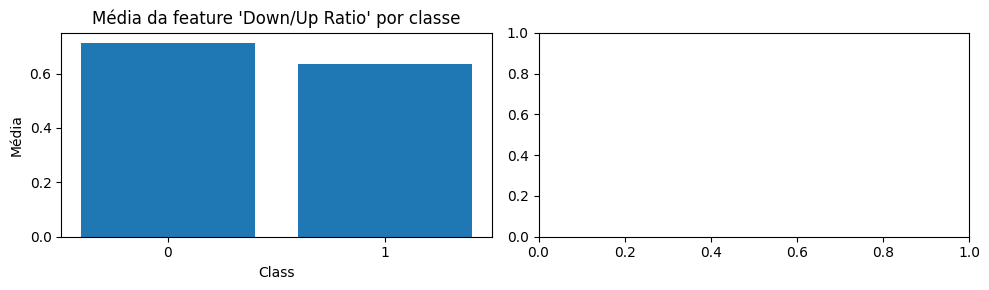

In [6]:
def plot_medias_por_classe(df):
    medias = df.groupby("Class").mean(numeric_only=True)
    cols = medias.columns
    n = len(cols)

    for i in range(0, n, 2):
        fig, axs = plt.subplots(1, 2, figsize=(10, 3))
        for j in range(2):
            if i + j < n:
                axs[j].bar(medias.index.astype(str), medias[cols[i + j]])
                axs[j].set_title(f"Média da feature '{cols[i + j]}' por classe")
                axs[j].set_xlabel("Class")
                axs[j].set_ylabel("Média")
        plt.tight_layout()
        plt.show()

plot_medias_por_classe(df)

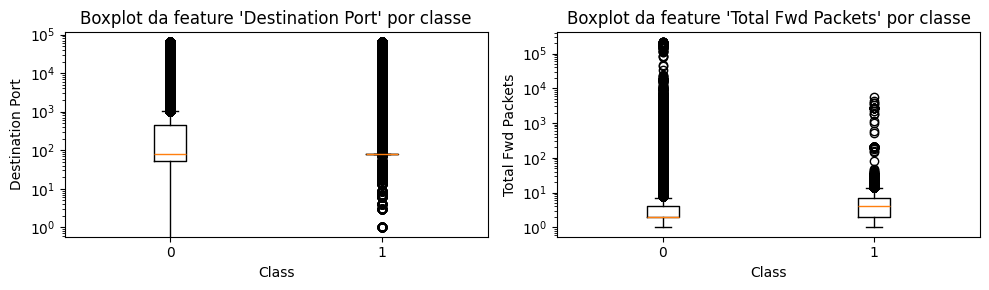

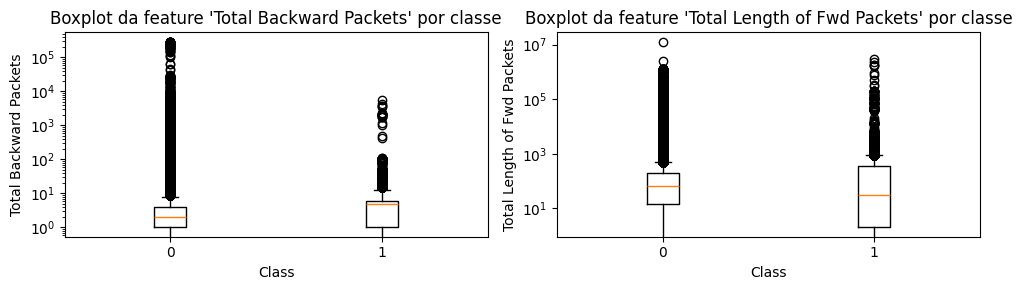

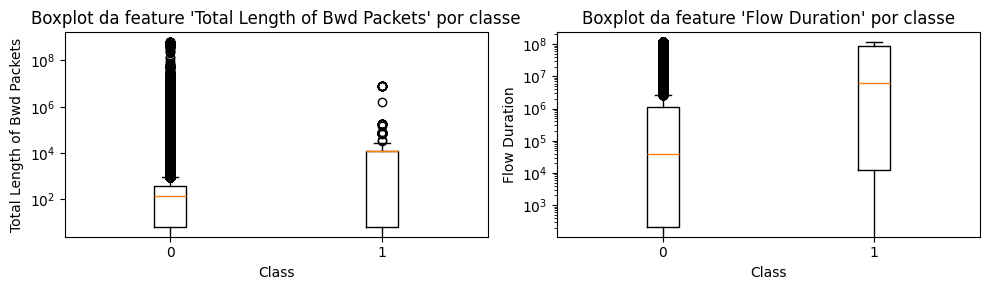

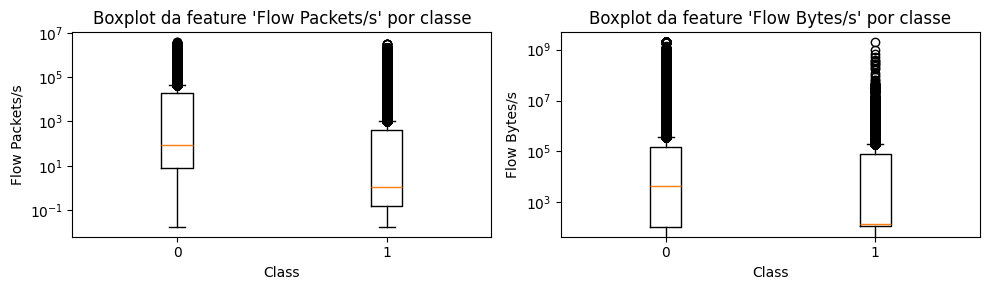

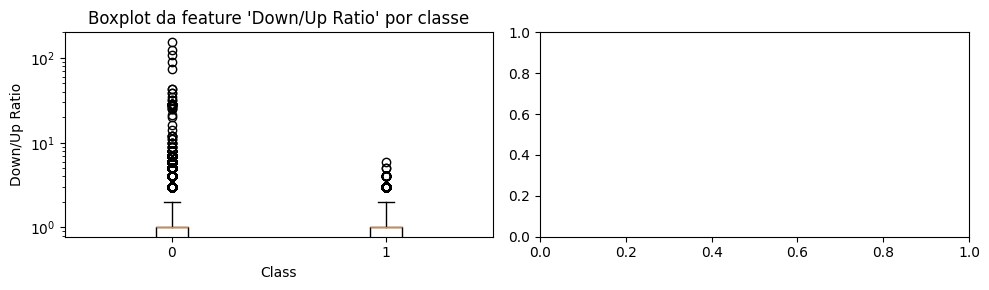

In [7]:
def plot_boxplots_por_classe(df, esc_log = False):
    cols = df.columns.drop("Class")  # exclui a coluna de classe
    n = len(cols)

    for i in range(0, n, 2):
        fig, axs = plt.subplots(1, 2, figsize=(10, 3))
        for j in range(2):
            if i + j < n:
                col = cols[i + j]
                axs[j].boxplot(
                    [df[df["Class"] == c][col] for c in sorted(df["Class"].unique())],
                    tick_labels=[str(c) for c in sorted(df["Class"].unique())]
                )
                axs[j].set_title(f"Boxplot da feature '{col}' por classe")
                axs[j].set_xlabel("Class")
                axs[j].set_ylabel(col)
                if esc_log:
                    axs[j].set_yscale("log")  # Coloca em escala logarítmica
        plt.tight_layout()
        plt.show()
plot_boxplots_por_classe(df, esc_log=True)

## Balanceamento

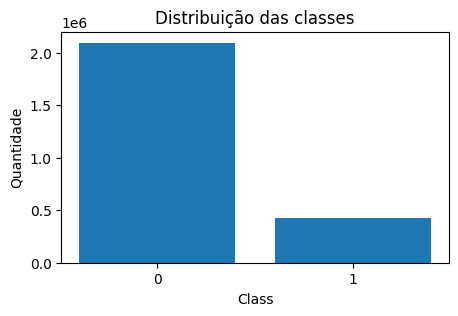

In [8]:
def plot_class_distribution(df, class_col="Class"):
    counts = df[class_col].value_counts().sort_index()
    plt.figure(figsize=(5,3))
    plt.bar(counts.index.astype(str), counts.values)
    plt.title("Distribuição das classes")
    plt.xlabel("Class")
    plt.ylabel("Quantidade")
    plt.show()
plot_class_distribution(df)

In [9]:
classe_0 = df[df["Class"] == 0]
classe_1 = df[df["Class"] == 1]


min_count = min(len(classe_0), len(classe_1))

# Faz o undersample da classe maior
classe_0_sample = classe_0.sample(n=min_count, random_state=42)
classe_1_sample = classe_1.sample(n=min_count, random_state=42)

# Junta as duas classes
df_undersampled = pd.concat([classe_0_sample, classe_1_sample])

# Embaralha o resultado
df_undersampled = df_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

## Analise dos dados apos undersampling

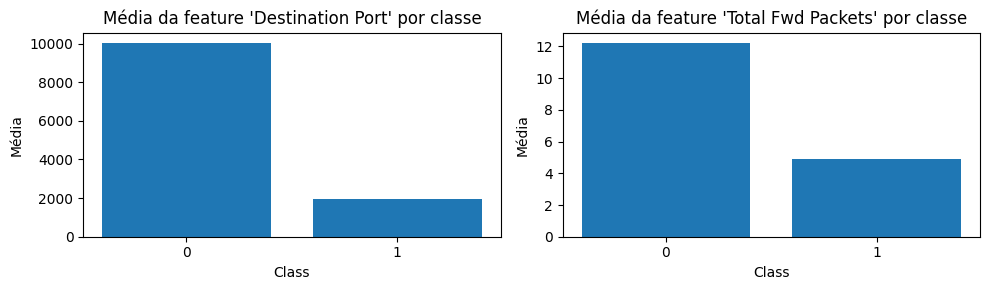

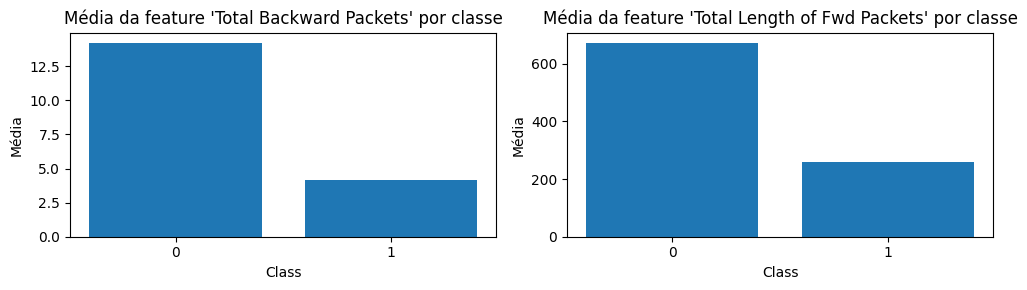

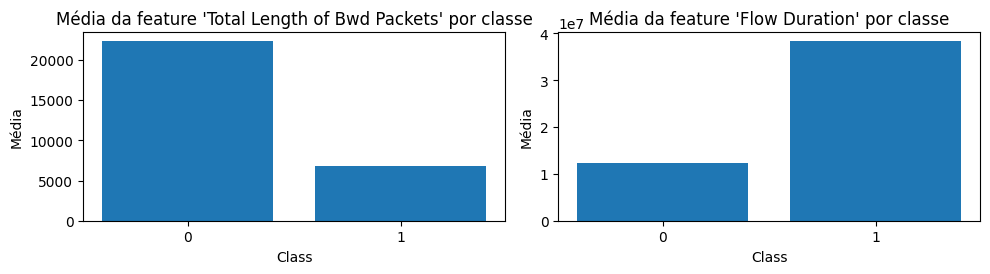

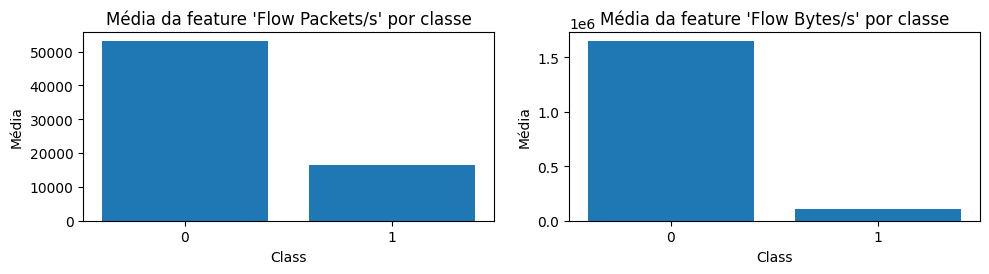

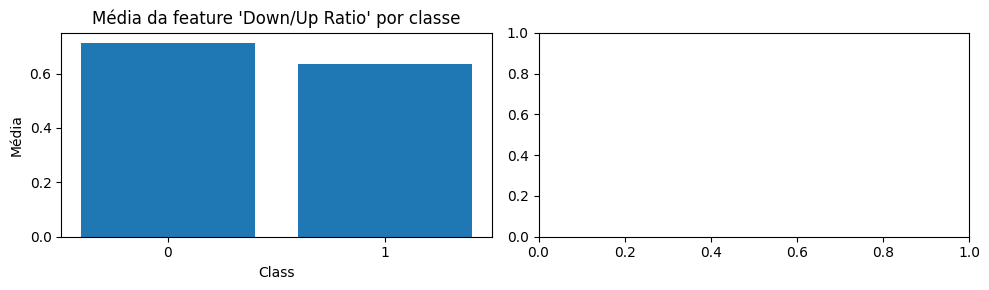

In [10]:
plot_medias_por_classe(df_undersampled)

# Remoção de Outliers

In [11]:
def remove_outliers_iqr(df, cols, factor=1.5):
    df_clean = df.copy()
    for col in cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

In [12]:
cols_numericas = df_undersampled.select_dtypes(include='number').columns.drop('Class')
df_undersampled_sem_outliers = remove_outliers_iqr(df_undersampled, cols_numericas)

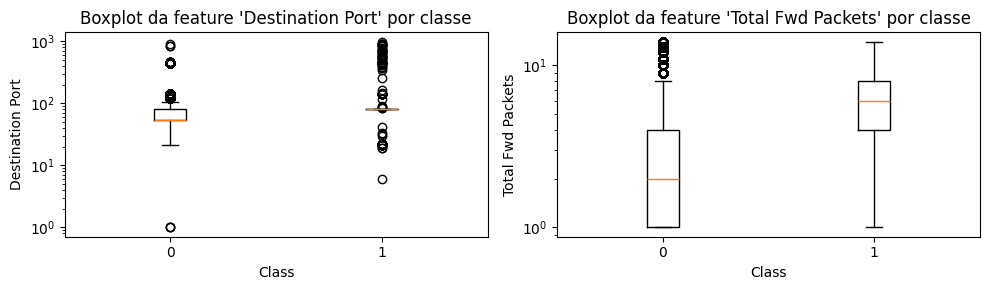

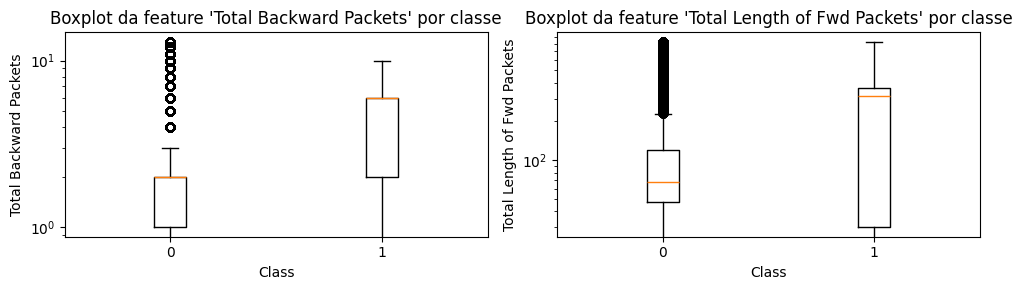

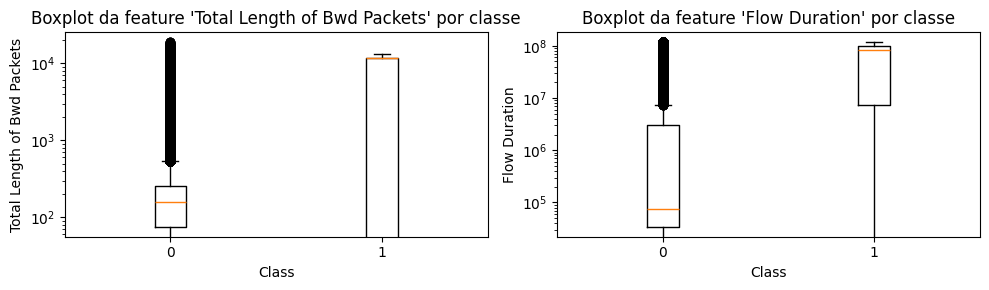

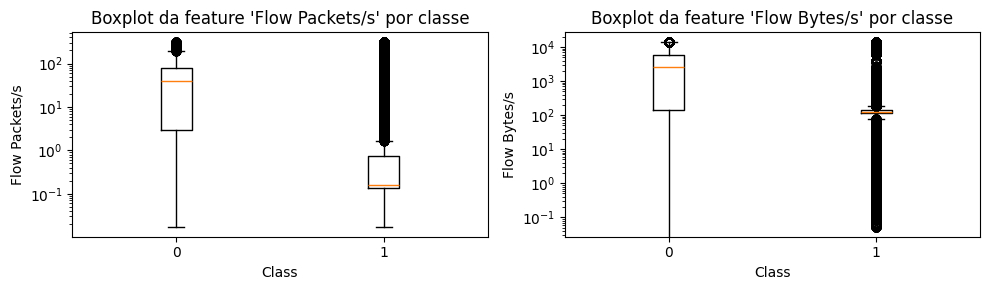

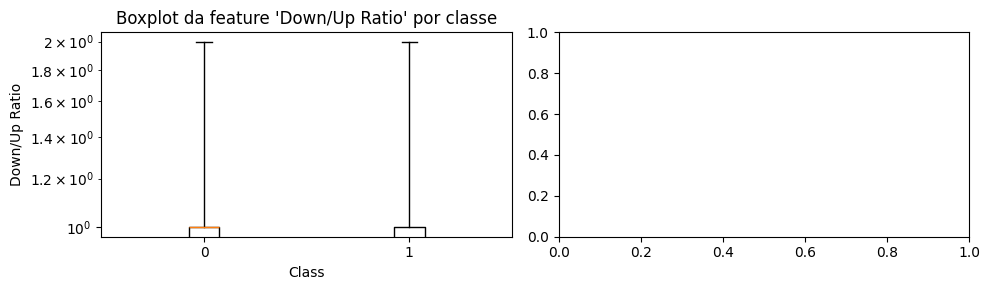

In [13]:
plot_boxplots_por_classe(df_undersampled_sem_outliers, esc_log=True)

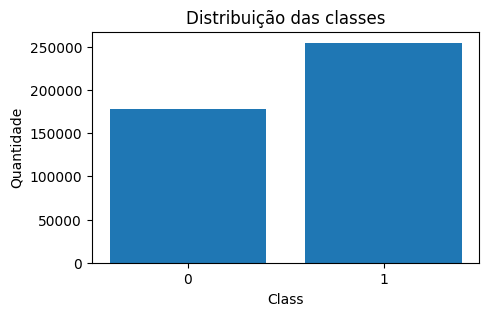

In [14]:
plot_class_distribution(df_undersampled_sem_outliers)

# Treinamento

In [15]:
X = df_undersampled_sem_outliers.iloc[:, :9]
y = df_undersampled_sem_outliers["Class"]

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
X_train_scaled.shape

(346546, 9)

In [19]:
#class VerboseRandomForest(RandomForestClassifier):
#    def fit(self, X, y, sample_weight=None):
#        print(f"Iniciando treinamento com {self.n_estimators} árvores...")
#        start = time.time()
#        for i in tqdm(range(self.n_estimators), desc="Treinando árvores"):
#            self.set_params(warm_start=True, n_estimators=i+1)
#            super().fit(X, y, sample_weight)
#        end = time.time()
#        print(f"Treinamento concluído em {end - start:.2f} segundos")
#        return self

In [20]:
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import time

randomForest = RandomForestClassifier(random_state=42, n_estimators=100, warm_start=True)
start = time.time()
randomForest.fit(X_train_scaled, y_train)
end = time.time()
print(f"Treinamento concluído em {end - start:.2f} segundos")

Treinamento concluído em 37.75 segundos


## Salvamento do Modelo e Scaler

In [21]:
import joblib
import os 

#Cria a pasta modelo caso não exista
os.makedirs("modelo", exist_ok=True)

# Salvar o modelo treinado
joblib.dump(randomForest, "./modelo/random_forest_model.joblib")

# Salvar o scaler
joblib.dump(scaler, "modelo/minmax_scaler.joblib")

['modelo/minmax_scaler.joblib']

## Avaliação do Modelo

In [22]:
y_predict = randomForest.predict(X_test_scaled)

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

def show_classification_metrics(y_true, y_pred):
    print("Acurácia:", accuracy_score(y_true, y_pred))
    print("Precisão:", precision_score(y_true, y_pred, average='binary'))
    print("Recall:", recall_score(y_true, y_pred, average='binary'))
    print("F1 Score:", f1_score(y_true, y_pred, average='binary'))
    print("\nRelatório de Classificação:")
    print(classification_report(y_true, y_pred))

    # Matriz de confusão gráfica
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')
    plt.show()

def plot_roc_auc(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR (False Positive Rate)')
    plt.ylabel('TPR (True Positive Rate)')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.show()
    print(f'AUC: {auc:.4f}')

Acurácia: 0.9943557602410056
Precisão: 0.9950354192421655
Recall: 0.9953674623115578
F1 Score: 0.9952014130808106

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     35693
           1       1.00      1.00      1.00     50944

    accuracy                           0.99     86637
   macro avg       0.99      0.99      0.99     86637
weighted avg       0.99      0.99      0.99     86637



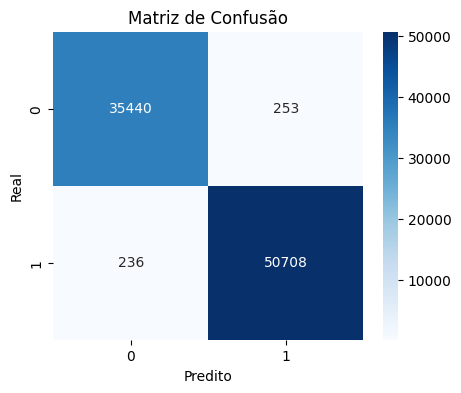

In [24]:
show_classification_metrics(y_test, y_predict)

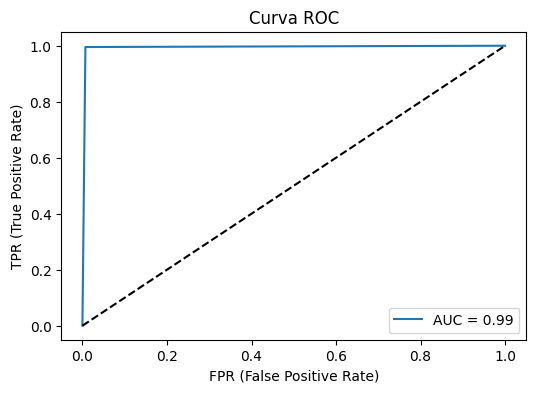

AUC: 0.9941


In [25]:
plot_roc_auc(y_test, y_predict)